In [117]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import sys
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")
from sklearn.model_selection import KFold # For Cross Validation
from pathlib import Path
import fastai # importing fastai library
from fastai.vision import *
from fastai import *
print("The version of Fastai is:",fastai.__version__)

1.0.61


In [118]:
data_path = Path("C:/Users/teckone/Desktop/COVID-19-master/X-Ray_Image_DataSet")
# Please choose the path of image accordingly
# For multiclass put all COVID-19 images, No-Finding images and pneumonia images in image database



In [100]:
# This block of code is for 5- fold cross validation
n_folds = 5
kf=KFold(n_splits=n_folds, shuffle= True)
data_files = list(data_path.glob('**/*.*'))
splits=list(kf.split(list(range(len(data_files)))))
len(data_files)

1125

In [119]:
# The 5 fold cross validation starts from fold = 0 to fold =4, we can put it manually or put in for loop. Here its done manually
fold=4
val_idx=splits[fold][1]
val_idx,len(val_idx)

(array([   3,    4,    9,   10,   11,   18,   23,   24,   34,   35,   38,   43,   46,   47,   49,   50,   52,   61,
          62,   64,   66,   72,   74,   80,   83,   85,   89,   97,   98,  129,  141,  163,  167,  177,  181,  185,
         186,  187,  193,  196,  210,  214,  219,  221,  226,  227,  234,  239,  249,  253,  256,  261,  267,  270,
         273,  275,  283,  284,  285,  294,  298,  303,  312,  320,  322,  327,  332,  335,  338,  364,  367,  371,
         377,  383,  390,  391,  393,  399,  403,  412,  418,  422,  427,  433,  434,  435,  439,  446,  450,  452,
         459,  465,  469,  471,  475,  478,  484,  490,  502,  512,  513,  529,  532,  540,  544,  545,  549,  551,
         553,  563,  568,  584,  588,  591,  592,  593,  596,  597,  600,  606,  612,  620,  623,  628,  630,  641,
         642,  649,  650,  651,  654,  656,  657,  664,  679,  694,  695,  697,  699,  704,  705,  709,  720,  723,
         727,  731,  740,  741,  742,  743,  745,  755,  763,  769,  770

In [120]:
data=(ImageList.from_folder(data_path)
      .split_by_idx(val_idx)
      .label_from_folder()
      .transform(get_transforms(),size=256)
      .databunch()
      .normalize()
     )

In [35]:
print(data.classes, len(data.train_ds), len(data.valid_ds))

['Covid-19', 'No_findings', 'Pneumonia'] 900 225


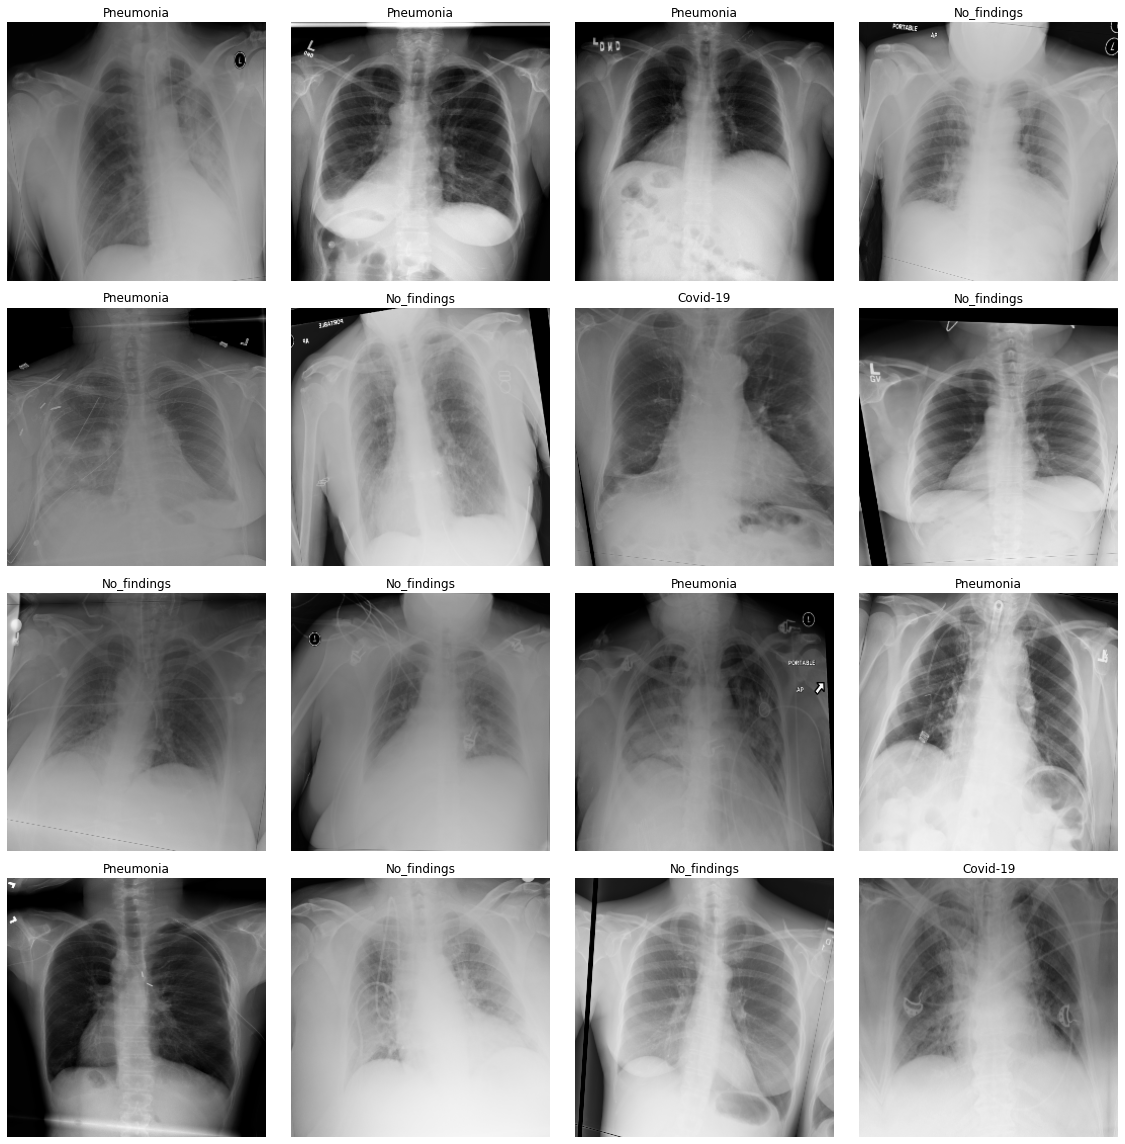

In [36]:
data.show_batch(rows=4)

In [121]:
# Darknet block (DN block)
def conv_block(in_channels, out_channels, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )    

In [122]:
# 3 X Convolution Block
def triple_conv(in_channels, out_channels):
    return nn.Sequential(
        conv_block(in_channels, out_channels),
        conv_block(out_channels, in_channels, size=1),  
        conv_block(in_channels, out_channels)
    )

In [123]:
# Maxpooling Layer
def maxpooling():
    return nn.MaxPool2d(kernel_size=2, stride=2)

In [124]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 3),
    Flatten(),
    nn.Linear(507, 3)
   
)

In [125]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [127]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [128]:
# train the model, epoch choosen here is 100 and learning rate 3e-3
learn.fit_one_cycle(100, max_lr=3e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.898217,1.080738,0.453333,00:37
1,0.797747,1.177601,0.426667,00:36
2,0.744182,0.801367,0.733333,00:36
3,0.698875,0.572418,0.760000,00:36
4,0.659214,0.802800,0.711111,00:36
5,0.634496,0.685535,0.702222,00:36
6,0.599575,0.486363,0.773333,00:37
7,0.579357,0.800640,0.635556,00:36
8,0.562164,0.521725,0.777778,00:36
9,0.538000,0.791048,0.706667,00:36


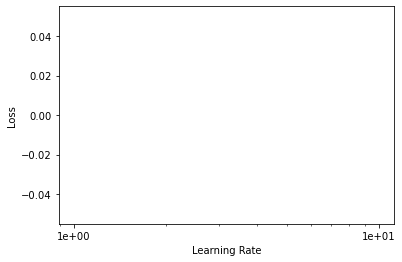

In [20]:
learn.recorder.plot()


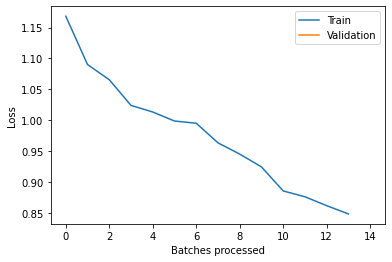

In [17]:
learn.recorder.plot_losses()

In [129]:
learn.export(data_path / f'fold{fold}.pk1') # save the trained data
learn.save(data_path / f'fold{fold}') # save the trained data

In [16]:
#learn = learn.load("C:/Users/user/Desktop/COVID-19-master/multiclass/fold0")

In [130]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 225


In [131]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid)

In [132]:
accuracy(probs,targets)

tensor(0.8489)

In [133]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) # shows whole confusion matrix
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings', 'Pneumonia']
print(classification_report(y_true1, y_pred1, target_names=target_names))

225 191 0.8488888888888889
[[26  1  2]
 [ 0 84 10]
 [ 0 21 81]]
              precision    recall  f1-score   support

    Covid-19       1.00      0.90      0.95        29
 No_findings       0.79      0.89      0.84        94
   Pneumonia       0.87      0.79      0.83       102

    accuracy                           0.85       225
   macro avg       0.89      0.86      0.87       225
weighted avg       0.85      0.85      0.85       225



In [134]:
interp = ClassificationInterpretation.from_learner(learn)

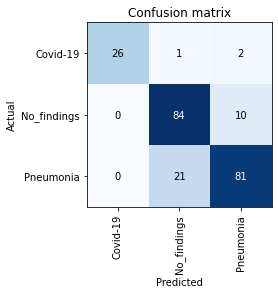

In [135]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);